Thanks for:

https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

https://upura.hatenablog.com/entry/2019/03/03/233534


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Add debug mode and minor modifications
# Version = "v3"  # minor modifications, DEBUG=True:CV:0.01672, False:CV:0.01636

Version = "v4" # Use anotated data, 

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.moa.lgbm.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=50
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Threshold = 0.6
Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201016_moa_sig_list.csv")
annot.head()

,sig_id,annot1,annot2,annot3
0,acetylcholine_receptor_agonist,acetylcholine_release_enhancer,NaN,NaN
1,acetylcholine_receptor_antagonist,atherogenesis_inhibitor,NaN,NaN
2,adenosine_receptor_antagonist,adenosine_deaminase_inhibitor,NaN,NaN
3,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN,NaN
4,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN,NaN


In [9]:
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['acetylcholine_receptor_agonist', 'acetylcholine_receptor_antagonist', 'adenosine_receptor_antagonist', 'adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'angiotensin_receptor_antagonist', 'anti-inflammatory', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'apoptosis_stimulant', 'atm_kinase_inhibitor', 'atp-sensitive_potassium_channel_antagonist', 'atp_synthase_inhibitor', 'atr_kinase_inhibitor', 'autotaxin_inhibitor', 'bacterial_membrane_integrity_inhibitor', 'bcr-abl_inhibitor', 'calcineurin_inhibitor', 'caspase_activator', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'chk_inhibitor', 'coagulation_factor_inhibitor', 'dopamine_receptor_agonist', 'elastase_inhibitor', 'erbb2_inhibitor', 'free_radical_scavenger', 'fungal_squalene_epoxidase_inhibitor', 'gaba_receptor_agonist', 'gaba_receptor_antagonist', 'glutamate_receptor_agonist', 'histamine_receptor_antagonist', 'histone_lysine_demethylase_inhibitor', 'hiv_inhibitor', 'imidazoline_re

In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1以上であれば1に置換
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    
    X_train = train.drop(["sig_id"], axis=1)
    y_train = get_target(target_col, annot_sig)
    X_test = test.drop(["sig_id"], axis=1)

    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    score = 0

    for fold_, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)

        oof_train[valid_index] = model.predict(X_val,
                                               num_iteration=model.best_iteration)
        y_pred = model.predict(X_test,
                               num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
        
    score = log_loss(y_train, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [14]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [15]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [16]:
train, test = label_encoding(train, test, ['cp_type', 'cp_dose'])

In [17]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# Modeling

In [18]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1

}

categorical_cols = ['cp_type', 'cp_dose']
oof = train_targets_scored.copy()
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [19]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[1:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0052987	valid_1's binary_logloss: 0.00558749


================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00505257	valid_1's binary_logloss: 0.00619707


5-alpha_reductase_inhibitor logloss: 0.005892282737485706
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00528889	valid_1's binary_logloss: 0.0061952


================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00556059	valid_1's binary_logloss: 0.00619414


11-beta-hsd1_inhibitor logloss: 0.006194670339008325
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00628035	valid_1's binary_logloss: 0.00793537


================================= fold 2/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00517702	valid_1's binary_logloss: 0.0078987


acat_inhibitor logloss: 0.007917034852462748
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0378023	valid_1's binary_logloss: 0.0477345


================================= fold 2/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0383997	valid_1's binary_logloss: 0.0476171


acetylcholine_receptor_agonist logloss: 0.047675812257817085
================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0263863	valid_1's binary_logloss: 0.0674447


================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0649109	valid_1's binary_logloss: 0.0688247


acetylcholine_receptor_antagonist logloss: 0.06813470181370242
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0193573	valid_1's binary_logloss: 0.0205356


================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0191005	valid_1's binary_logloss: 0.0210135


acetylcholinesterase_inhibitor logloss: 0.020774536719624443
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00867386	valid_1's binary_logloss: 0.0160555


================================= fold 2/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00700976	valid_1's binary_logloss: 0.0160492


adenosine_receptor_agonist logloss: 0.016052306486671438
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0222102	valid_1's binary_logloss: 0.0263373


================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0242246	valid_1's binary_logloss: 0.0262788


adenosine_receptor_antagonist logloss: 0.026308079801988526
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00160681	valid_1's binary_logloss: 0.00596897


================================= fold 2/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.000988414	valid_1's binary_logloss: 0.0057363


adenylyl_cyclase_activator logloss: 0.005852634292197096
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0192856	valid_1's binary_logloss: 0.059989


================================= fold 2/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0223247	valid_1's binary_logloss: 0.0603305


adrenergic_receptor_agonist logloss: 0.06015979312067918
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	training's binary_logloss: 0.0357696	valid_1's binary_logloss: 0.0771663


================================= fold 2/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0414355	valid_1's binary_logloss: 0.0768704


adrenergic_receptor_antagonist logloss: 0.0770183314440831
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.00262325	valid_1's binary_logloss: 0.0163762


================================= fold 2/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00277354	valid_1's binary_logloss: 0.0164682


akt_inhibitor logloss: 0.016422175774056313
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00615053	valid_1's binary_logloss: 0.00619452


================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00218576	valid_1's binary_logloss: 0.00648689


aldehyde_dehydrogenase_inhibitor logloss: 0.006340707174817939
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00235289	valid_1's binary_logloss: 0.0122498


================================= fold 2/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00284478	valid_1's binary_logloss: 0.0123518


alk_inhibitor logloss: 0.012300783650208013
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00250596	valid_1's binary_logloss: 0.00433142


================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00392146	valid_1's binary_logloss: 0.00426431


ampk_activator logloss: 0.004297861215790056
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0028841	valid_1's binary_logloss: 0.00428751


================================= fold 2/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00402851	valid_1's binary_logloss: 0.00433174


analgesic logloss: 0.004309624974805149
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0126955	valid_1's binary_logloss: 0.0145004


================================= fold 2/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0132387	valid_1's binary_logloss: 0.0144925


androgen_receptor_agonist logloss: 0.01449649420939636
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0231441	valid_1's binary_logloss: 0.0244433


================================= fold 2/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0190167	valid_1's binary_logloss: 0.0248879


androgen_receptor_antagonist logloss: 0.024665633310435142
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0209003	valid_1's binary_logloss: 0.0225286


================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0187138	valid_1's binary_logloss: 0.0225281


anesthetic_-_local logloss: 0.02252833934158737
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00893734	valid_1's binary_logloss: 0.0113316


================================= fold 2/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00670498	valid_1's binary_logloss: 0.0112831


angiogenesis_inhibitor logloss: 0.01130735256770238
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0220784	valid_1's binary_logloss: 0.0334699


================================= fold 2/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0240029	valid_1's binary_logloss: 0.0334868


angiotensin_receptor_antagonist logloss: 0.033478317794098184
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0252379	valid_1's binary_logloss: 0.0365975


================================= fold 2/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0173889	valid_1's binary_logloss: 0.036608


anti-inflammatory logloss: 0.03660274671590815
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0257711	valid_1's binary_logloss: 0.0280475


================================= fold 2/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0263441	valid_1's binary_logloss: 0.0280572


antiarrhythmic logloss: 0.028052365198262073
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.00379994	valid_1's binary_logloss: 0.0122658


================================= fold 2/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0103307	valid_1's binary_logloss: 0.0134758


antibiotic logloss: 0.012870800606129277
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00577834	valid_1's binary_logloss: 0.00619278


================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00308966	valid_1's binary_logloss: 0.00615098


anticonvulsant logloss: 0.0061718790669182235
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00782419	valid_1's binary_logloss: 0.00854723


================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.007824	valid_1's binary_logloss: 0.00854864


antifungal logloss: 0.008547938497388722
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0054478	valid_1's binary_logloss: 0.00619287


================================= fold 2/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00573487	valid_1's binary_logloss: 0.00619388


antihistamine logloss: 0.006193374960413548
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00536255	valid_1's binary_logloss: 0.00619063


================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00457103	valid_1's binary_logloss: 0.00613436


antimalarial logloss: 0.006162492641929111
================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0127839	valid_1's binary_logloss: 0.020568


================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0123731	valid_1's binary_logloss: 0.0208977


antioxidant logloss: 0.020732870403740413
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00991826	valid_1's binary_logloss: 0.0113478


================================= fold 2/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00980391	valid_1's binary_logloss: 0.0112914


antiprotozoal logloss: 0.011319572384161654
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00242942	valid_1's binary_logloss: 0.00736265


================================= fold 2/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00677246	valid_1's binary_logloss: 0.00797354


antiviral logloss: 0.007668096658162331
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.0103177	valid_1's binary_logloss: 0.0276922


================================= fold 2/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0138306	valid_1's binary_logloss: 0.0287703


apoptosis_stimulant logloss: 0.028231266044327713
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0117676	valid_1's binary_logloss: 0.0140167


================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0122728	valid_1's binary_logloss: 0.0145678


aromatase_inhibitor logloss: 0.014292247113290748
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.00639408	valid_1's binary_logloss: 0.0331109


================================= fold 2/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0067689	valid_1's binary_logloss: 0.0324776


atm_kinase_inhibitor logloss: 0.032794242863811454
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00191375	valid_1's binary_logloss: 0.00234633


================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.000676692	valid_1's binary_logloss: 0.00289484


atp-sensitive_potassium_channel_antagonist logloss: 0.00262058496527707
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	training's binary_logloss: 0.000178003	valid_1's binary_logloss: 0.00452109


================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.000135695	valid_1's binary_logloss: 0.00331991
Early stopping, best iteration is:
[104]	training's binary_logloss: 0.000125751	valid_1's binary_logloss: 0.00329741


atp_synthase_inhibitor logloss: 0.003909248952740205
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00389871	valid_1's binary_logloss: 0.0218273


================================= fold 2/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00713604	valid_1's binary_logloss: 0.0241893


atpase_inhibitor logloss: 0.023008307517397898
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.000790082	valid_1's binary_logloss: 0.00955987


================================= fold 2/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.000309385	valid_1's binary_logloss: 0.00930726
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.000322729	valid_1's binary_logloss: 0.0093037


atr_kinase_inhibitor logloss: 0.009431785469434701
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00155473	valid_1's binary_logloss: 0.0178063


================================= fold 2/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00138289	valid_1's binary_logloss: 0.0170806


aurora_kinase_inhibitor logloss: 0.01744343722274507
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00539442	valid_1's binary_logloss: 0.0112757


================================= fold 2/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00894564	valid_1's binary_logloss: 0.0112974


autotaxin_inhibitor logloss: 0.011286524887426878
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0164462	valid_1's binary_logloss: 0.0176284


================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0156114	valid_1's binary_logloss: 0.0176521


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.017640254205821455
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0203369	valid_1's binary_logloss: 0.0225865


================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0201658	valid_1's binary_logloss: 0.0225187


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.02255262181187911
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00950579	valid_1's binary_logloss: 0.0111935


================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0086082	valid_1's binary_logloss: 0.0112625


bacterial_antifolate logloss: 0.011227976615939687
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.046162	valid_1's binary_logloss: 0.0468339


================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0262103	valid_1's binary_logloss: 0.0468745


bacterial_cell_wall_synthesis_inhibitor logloss: 0.04685418241837757
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0105805	valid_1's binary_logloss: 0.0243166


================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0227584	valid_1's binary_logloss: 0.0248792


bacterial_dna_gyrase_inhibitor logloss: 0.024597895452436954
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0284317	valid_1's binary_logloss: 0.0303529


================================= fold 2/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0133322	valid_1's binary_logloss: 0.0306049


bacterial_dna_inhibitor logloss: 0.030478936270792244
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00492687	valid_1's binary_logloss: 0.00564332


================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00218966	valid_1's binary_logloss: 0.00643732


bacterial_membrane_integrity_inhibitor logloss: 0.006040322772749651
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00925924	valid_1's binary_logloss: 0.00954764


================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00177898	valid_1's binary_logloss: 0.00981262


bcl_inhibitor logloss: 0.009680126694340702
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00743691	valid_1's binary_logloss: 0.0175439


================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00748202	valid_1's binary_logloss: 0.0182292


bcr-abl_inhibitor logloss: 0.01788654013001385
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00716324	valid_1's binary_logloss: 0.019127


================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0148205	valid_1's binary_logloss: 0.0194683


benzodiazepine_receptor_agonist logloss: 0.01929764884321491
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00701363	valid_1's binary_logloss: 0.00796803


================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00718679	valid_1's binary_logloss: 0.00796807


beta_amyloid_inhibitor logloss: 0.007968051935789226
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0019509	valid_1's binary_logloss: 0.0154121


================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00268379	valid_1's binary_logloss: 0.0148188


bromodomain_inhibitor logloss: 0.015115476717376241
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00846864	valid_1's binary_logloss: 0.00910134


================================= fold 2/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00772457	valid_1's binary_logloss: 0.00958721


btk_inhibitor logloss: 0.009344278347779577
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00387677	valid_1's binary_logloss: 0.00433431


================================= fold 2/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00165078	valid_1's binary_logloss: 0.00432023


calcineurin_inhibitor logloss: 0.004327267240299035
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0586233	valid_1's binary_logloss: 0.0639002


================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.0306471	valid_1's binary_logloss: 0.06376


calcium_channel_blocker logloss: 0.06383009951110849
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0112895	valid_1's binary_logloss: 0.0129777


================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0116238	valid_1's binary_logloss: 0.0129132


cannabinoid_receptor_agonist logloss: 0.012945444318071734
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0142069	valid_1's binary_logloss: 0.0160595


================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0147417	valid_1's binary_logloss: 0.0165355


cannabinoid_receptor_antagonist logloss: 0.016297509248371256
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0102358	valid_1's binary_logloss: 0.0113467


================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0105067	valid_1's binary_logloss: 0.0113475


carbonic_anhydrase_inhibitor logloss: 0.011347058281062198
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00567775	valid_1's binary_logloss: 0.0111391


================================= fold 2/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0100347	valid_1's binary_logloss: 0.0112178


casein_kinase_inhibitor logloss: 0.011178452548636903
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.00830028	valid_1's binary_logloss: 0.0159624


================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.0079717	valid_1's binary_logloss: 0.0164612


caspase_activator logloss: 0.01621181863465925
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00578242	valid_1's binary_logloss: 0.00619011


================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00560368	valid_1's binary_logloss: 0.00619274


catechol_o_methyltransferase_inhibitor logloss: 0.006191424154064015
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0253041	valid_1's binary_logloss: 0.02769


================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0218353	valid_1's binary_logloss: 0.0275421


cc_chemokine_receptor_antagonist logloss: 0.02761604891883328
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00351221	valid_1's binary_logloss: 0.0061385


================================= fold 2/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0057327	valid_1's binary_logloss: 0.00619342


cck_receptor_antagonist logloss: 0.006165959446845941
================================= fold 1/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.00377221	valid_1's binary_logloss: 0.0275487


================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00294588	valid_1's binary_logloss: 0.0262025
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00287689	valid_1's binary_logloss: 0.0261941


cdk_inhibitor logloss: 0.026871381284676643
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.01493	valid_1's binary_logloss: 0.0161114


================================= fold 2/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0152912	valid_1's binary_logloss: 0.016087


chelating_agent logloss: 0.016099239421804704
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.000790082	valid_1's binary_logloss: 0.00955987


================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.000309385	valid_1's binary_logloss: 0.00930726
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.000322729	valid_1's binary_logloss: 0.0093037


chk_inhibitor logloss: 0.009431785469434701
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0120074	valid_1's binary_logloss: 0.0129646


================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00859085	valid_1's binary_logloss: 0.0129412


chloride_channel_blocker logloss: 0.012952910654667681
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0133203	valid_1's binary_logloss: 0.0144788


================================= fold 2/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0133769	valid_1's binary_logloss: 0.0144112


cholesterol_inhibitor logloss: 0.014444965761380575
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00904381	valid_1's binary_logloss: 0.0160591


================================= fold 2/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0120597	valid_1's binary_logloss: 0.0160489


cholinergic_receptor_antagonist logloss: 0.01605395750988471
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00449434	valid_1's binary_logloss: 0.00796013


================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00534425	valid_1's binary_logloss: 0.00791914


coagulation_factor_inhibitor logloss: 0.007939635122982163
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00142539	valid_1's binary_logloss: 0.0104035


================================= fold 2/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	training's binary_logloss: 0.001352	valid_1's binary_logloss: 0.0093204


corticosteroid_agonist logloss: 0.009861942076034575
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0470086	valid_1's binary_logloss: 0.0896889


================================= fold 2/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0456159	valid_1's binary_logloss: 0.0889916


cyclooxygenase_inhibitor logloss: 0.08934026536444911
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.020229	valid_1's binary_logloss: 0.0276951


================================= fold 2/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0100942	valid_1's binary_logloss: 0.0279171


cytochrome_p450_inhibitor logloss: 0.027806080046012194
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00169553	valid_1's binary_logloss: 0.00953953


================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00372596	valid_1's binary_logloss: 0.0107822


dihydrofolate_reductase_inhibitor logloss: 0.01016085318136573
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00751368	valid_1's binary_logloss: 0.00797059


================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00734433	valid_1's binary_logloss: 0.00854977


dipeptidyl_peptidase_inhibitor logloss: 0.00826017811241838
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0022212	valid_1's binary_logloss: 0.00234056


================================= fold 2/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212593	valid_1's binary_logloss: 0.00234061


diuretic logloss: 0.0023405862227867625
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.00652705	valid_1's binary_logloss: 0.0144475


================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00530181	valid_1's binary_logloss: 0.0141786


dna_alkylating_agent logloss: 0.014313036020714882
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	training's binary_logloss: 0.0245891	valid_1's binary_logloss: 0.0816035


================================= fold 2/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0360084	valid_1's binary_logloss: 0.0815243


dna_inhibitor logloss: 0.08156394225758942
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0294921	valid_1's binary_logloss: 0.0328299


================================= fold 2/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0157497	valid_1's binary_logloss: 0.0332327


dopamine_receptor_agonist logloss: 0.03303132208567574
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0289882	valid_1's binary_logloss: 0.0854369


================================= fold 2/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.0375558	valid_1's binary_logloss: 0.0870118


dopamine_receptor_antagonist logloss: 0.08622434960125258
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00289566	valid_1's binary_logloss: 0.0332947
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.00177397	valid_1's binary_logloss: 0.033057


================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00295047	valid_1's binary_logloss: 0.0332505
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.00253219	valid_1's binary_logloss: 0.0332299


egfr_inhibitor logloss: 0.033143428954662546
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00392173	valid_1's binary_logloss: 0.00433226


================================= fold 2/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00401343	valid_1's binary_logloss: 0.00433343


elastase_inhibitor logloss: 0.004332849401389945
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00428404	valid_1's binary_logloss: 0.00669558


================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00413233	valid_1's binary_logloss: 0.00670653


erbb2_inhibitor logloss: 0.006701055704152678
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.0214512	valid_1's binary_logloss: 0.0395325


================================= fold 2/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0323109	valid_1's binary_logloss: 0.0399715


estrogen_receptor_agonist logloss: 0.03975199971740233
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00995883	valid_1's binary_logloss: 0.0144415


================================= fold 2/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.00417773	valid_1's binary_logloss: 0.0143213


estrogen_receptor_antagonist logloss: 0.01438138588426076
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0103789	valid_1's binary_logloss: 0.011279


================================= fold 2/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00363807	valid_1's binary_logloss: 0.0112019


faah_inhibitor logloss: 0.011240438246257605
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.000451134	valid_1's binary_logloss: 0.00592809


================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.000919327	valid_1's binary_logloss: 0.00562464


farnesyltransferase_inhibitor logloss: 0.005776364802029367
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0078921	valid_1's binary_logloss: 0.00797467


================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0061477	valid_1's binary_logloss: 0.00851487


fatty_acid_receptor_agonist logloss: 0.008244769960789804
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00147427	valid_1's binary_logloss: 0.0132062


================================= fold 2/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00222298	valid_1's binary_logloss: 0.0138075


fgfr_inhibitor logloss: 0.013506828298729418
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0036859	valid_1's binary_logloss: 0.0318976


================================= fold 2/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00267644	valid_1's binary_logloss: 0.0303186
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.00211738	valid_1's binary_logloss: 0.0302807


flt3_inhibitor logloss: 0.031089124789870106
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.000633807	valid_1's binary_logloss: 0.00558218


================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.000304235	valid_1's binary_logloss: 0.0047568


focal_adhesion_kinase_inhibitor logloss: 0.005169487529955707
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0167105	valid_1's binary_logloss: 0.0248267


================================= fold 2/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0186216	valid_1's binary_logloss: 0.0252248


free_radical_scavenger logloss: 0.02502575698609168
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00322388	valid_1's binary_logloss: 0.00904609


================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00835663	valid_1's binary_logloss: 0.00969019


fungal_squalene_epoxidase_inhibitor logloss: 0.00936814013490865
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0230218	valid_1's binary_logloss: 0.0333491


================================= fold 2/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0273904	valid_1's binary_logloss: 0.0336709


gaba_receptor_agonist logloss: 0.03350999472715868
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0226507	valid_1's binary_logloss: 0.0423262


================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0372348	valid_1's binary_logloss: 0.042872


gaba_receptor_antagonist logloss: 0.04259907125128645
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00209627	valid_1's binary_logloss: 0.0133832


================================= fold 2/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00221253	valid_1's binary_logloss: 0.0145534


gamma_secretase_inhibitor logloss: 0.013968284337062889
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00223651	valid_1's binary_logloss: 0.0133365
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.00138772	valid_1's binary_logloss: 0.0132239


================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00202679	valid_1's binary_logloss: 0.0157976
Early stopping, best iteration is:
[100]	training's binary_logloss: 0.00202679	valid_1's binary_logloss: 0.0157976


glucocorticoid_receptor_agonist logloss: 0.014510751114679418
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00471718	valid_1's binary_logloss: 0.00433534


================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00362602	valid_1's binary_logloss: 0.00491274


glutamate_inhibitor logloss: 0.004624038739520439
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0137709	valid_1's binary_logloss: 0.0223741


================================= fold 2/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0206645	valid_1's binary_logloss: 0.0225372


glutamate_receptor_agonist logloss: 0.02245561980722395
================================= fold 1/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0391862	valid_1's binary_logloss: 0.0781574


================================= fold 2/2 glutamate_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.0520146	valid_1's binary_logloss: 0.0791208


glutamate_receptor_antagonist logloss: 0.07863906946863576
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00556098	valid_1's binary_logloss: 0.00619293


================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00448446	valid_1's binary_logloss: 0.0060735


gonadotropin_receptor_agonist logloss: 0.006133217127432438
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.00238971	valid_1's binary_logloss: 0.0137765


================================= fold 2/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00198139	valid_1's binary_logloss: 0.0136221


gsk_inhibitor logloss: 0.013699307973354424
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0194588	valid_1's binary_logloss: 0.0206044


================================= fold 2/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0198557	valid_1's binary_logloss: 0.0205408


hcv_inhibitor logloss: 0.020572557798241145
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.00142398	valid_1's binary_logloss: 0.0114848


================================= fold 2/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00211743	valid_1's binary_logloss: 0.0186331


hdac_inhibitor logloss: 0.015058971756890154
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0161318	valid_1's binary_logloss: 0.0171243


================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0154797	valid_1's binary_logloss: 0.0176275


histamine_receptor_agonist logloss: 0.01737586913394994
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0554266	valid_1's binary_logloss: 0.0576456


================================= fold 2/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0565011	valid_1's binary_logloss: 0.0578359


histamine_receptor_antagonist logloss: 0.057740751828326144
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00601989	valid_1's binary_logloss: 0.0142501


================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00524798	valid_1's binary_logloss: 0.014784


histone_lysine_demethylase_inhibitor logloss: 0.01451709175629772
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00272853	valid_1's binary_logloss: 0.0101476


================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.00211917	valid_1's binary_logloss: 0.00997721


histone_lysine_methyltransferase_inhibitor logloss: 0.010062428810353232
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0193306	valid_1's binary_logloss: 0.0220857


================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0203147	valid_1's binary_logloss: 0.0220488


hiv_inhibitor logloss: 0.02206726675389038
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00216738	valid_1's binary_logloss: 0.0190397
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.000828538	valid_1's binary_logloss: 0.0184963


================================= fold 2/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00216335	valid_1's binary_logloss: 0.0172735
Early stopping, best iteration is:
[186]	training's binary_logloss: 0.000426261	valid_1's binary_logloss: 0.0160727


hmgcr_inhibitor logloss: 0.017284524648460902
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.000586795	valid_1's binary_logloss: 0.00749912
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.000713185	valid_1's binary_logloss: 0.00747563


================================= fold 2/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.000926508	valid_1's binary_logloss: 0.00877655


hsp_inhibitor logloss: 0.008126091800629362
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00185897	valid_1's binary_logloss: 0.0105367


================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00176558	valid_1's binary_logloss: 0.0116342


igf-1_inhibitor logloss: 0.011085488833227398
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.00211886	valid_1's binary_logloss: 0.00872998


================================= fold 2/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[49]	training's binary_logloss: 0.000827484	valid_1's binary_logloss: 0.00823615


ikk_inhibitor logloss: 0.008483067903370377
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0105594	valid_1's binary_logloss: 0.0113448


================================= fold 2/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.010478	valid_1's binary_logloss: 0.0118969


imidazoline_receptor_agonist logloss: 0.011620805767438208
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00462672	valid_1's binary_logloss: 0.0195205


================================= fold 2/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	training's binary_logloss: 0.00590076	valid_1's binary_logloss: 0.0202635


immunosuppressant logloss: 0.019892020129127486
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0089263	valid_1's binary_logloss: 0.00968304


================================= fold 2/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00856732	valid_1's binary_logloss: 0.00968309


insulin_secretagogue logloss: 0.009683066010807605
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00235571	valid_1's binary_logloss: 0.0139636


================================= fold 2/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.00391003	valid_1's binary_logloss: 0.0151579


insulin_sensitizer logloss: 0.014560706462052962
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.012099	valid_1's binary_logloss: 0.0129636


================================= fold 2/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00760271	valid_1's binary_logloss: 0.0129387


integrin_inhibitor logloss: 0.012951166576967751
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00239356	valid_1's binary_logloss: 0.0198664


================================= fold 2/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00191516	valid_1's binary_logloss: 0.0190919


jak_inhibitor logloss: 0.01947915991372929
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00235182	valid_1's binary_logloss: 0.0251379
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.00184678	valid_1's binary_logloss: 0.0250338


================================= fold 2/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00241885	valid_1's binary_logloss: 0.0230815
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00198145	valid_1's binary_logloss: 0.0229621


kit_inhibitor logloss: 0.023997957491429425
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.000449336	valid_1's binary_logloss: 0.00224047


================================= fold 2/2 laxative=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0020085	valid_1's binary_logloss: 0.00233931


laxative logloss: 0.0022898899986191243
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.0086488	valid_1's binary_logloss: 0.0187921


================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0182769	valid_1's binary_logloss: 0.0195319


leukotriene_inhibitor logloss: 0.01916202455866134
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0168627	valid_1's binary_logloss: 0.0181356


================================= fold 2/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0159285	valid_1's binary_logloss: 0.0179087


leukotriene_receptor_antagonist logloss: 0.018022154205457164
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00410474	valid_1's binary_logloss: 0.00433222


================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00388937	valid_1's binary_logloss: 0.00433397


lipase_inhibitor logloss: 0.004333092097120686
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0169213	valid_1's binary_logloss: 0.0176286


================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00977568	valid_1's binary_logloss: 0.01796


lipoxygenase_inhibitor logloss: 0.017794294287271487
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.000313971	valid_1's binary_logloss: 0.00223522


================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.000704663	valid_1's binary_logloss: 0.0022042


lxr_agonist logloss: 0.0022197102239271877
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[65]	training's binary_logloss: 0.000565363	valid_1's binary_logloss: 0.00646629


================================= fold 2/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.000861571	valid_1's binary_logloss: 0.0084994


mdm_inhibitor logloss: 0.007482845310826336
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00298654	valid_1's binary_logloss: 0.0231065


================================= fold 2/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.00393156	valid_1's binary_logloss: 0.0248584


mek_inhibitor logloss: 0.023982430437190328
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0195687	valid_1's binary_logloss: 0.0211038


================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.010534	valid_1's binary_logloss: 0.0209414


membrane_integrity_inhibitor logloss: 0.021022629120005108
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00774844	valid_1's binary_logloss: 0.00797472


================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00709676	valid_1's binary_logloss: 0.00855354


mineralocorticoid_receptor_antagonist logloss: 0.008264131739780974
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00387599	valid_1's binary_logloss: 0.00433195


================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00390727	valid_1's binary_logloss: 0.00433468


monoacylglycerol_lipase_inhibitor logloss: 0.004333317389036853
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0217355	valid_1's binary_logloss: 0.0235182


================================= fold 2/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.020891	valid_1's binary_logloss: 0.0240011


monoamine_oxidase_inhibitor logloss: 0.023759677339807182
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00554727	valid_1's binary_logloss: 0.00619704


================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.001197	valid_1's binary_logloss: 0.00616183


monopolar_spindle_1_kinase_inhibitor logloss: 0.006179434800729468
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00257938	valid_1's binary_logloss: 0.0219718


================================= fold 2/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.00193377	valid_1's binary_logloss: 0.018535


mtor_inhibitor logloss: 0.02025336342727003
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00726347	valid_1's binary_logloss: 0.0144666


================================= fold 2/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00469671	valid_1's binary_logloss: 0.0144998


mucolytic_agent logloss: 0.014483219086244723
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00956535	valid_1's binary_logloss: 0.0113357


================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00817531	valid_1's binary_logloss: 0.0118552


neuropeptide_receptor_antagonist logloss: 0.011595440354350003
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00858323	valid_1's binary_logloss: 0.0276085
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.00487376	valid_1's binary_logloss: 0.0267659


================================= fold 2/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00637317	valid_1's binary_logloss: 0.0379059
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.00608035	valid_1's binary_logloss: 0.0378912


nfkb_inhibitor logloss: 0.0323285307032466
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0037408	valid_1's binary_logloss: 0.00433444


================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00373888	valid_1's binary_logloss: 0.00433287


nicotinic_receptor_agonist logloss: 0.004333654326519547
================================= fold 1/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00779426	valid_1's binary_logloss: 0.00854484


================================= fold 2/2 nitric_oxide_donor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0074826	valid_1's binary_logloss: 0.00855431


nitric_oxide_donor logloss: 0.008549573211138126
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00567455	valid_1's binary_logloss: 0.00908285


================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00736588	valid_1's binary_logloss: 0.0096395


nitric_oxide_production_inhibitor logloss: 0.009361175421055199
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00785281	valid_1's binary_logloss: 0.00854655


================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00751007	valid_1's binary_logloss: 0.00854756


nitric_oxide_synthase_inhibitor logloss: 0.008547053596029962
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.00608235	valid_1's binary_logloss: 0.0128283


================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00987775	valid_1's binary_logloss: 0.0133977


norepinephrine_reuptake_inhibitor logloss: 0.013113027636625958
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.000625767	valid_1's binary_logloss: 0.00503177


================================= fold 2/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00109986	valid_1's binary_logloss: 0.005646


nrf2_activator logloss: 0.005338885553046958
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0150683	valid_1's binary_logloss: 0.0175741


================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0152209	valid_1's binary_logloss: 0.0180449


opioid_receptor_agonist logloss: 0.017809503696455294
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0249258	valid_1's binary_logloss: 0.0262502


================================= fold 2/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0159575	valid_1's binary_logloss: 0.0261447


opioid_receptor_antagonist logloss: 0.026197430266453794
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00959006	valid_1's binary_logloss: 0.0112913


================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00895214	valid_1's binary_logloss: 0.0118528


orexin_receptor_antagonist logloss: 0.011572011348237812
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00198945	valid_1's binary_logloss: 0.0135511


================================= fold 2/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.00194931	valid_1's binary_logloss: 0.0135722


p38_mapk_inhibitor logloss: 0.013561612659533425
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00876321	valid_1's binary_logloss: 0.00968609


================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00880756	valid_1's binary_logloss: 0.00968539


p-glycoprotein_inhibitor logloss: 0.009685740017606323
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0115759	valid_1's binary_logloss: 0.0175182


================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0141902	valid_1's binary_logloss: 0.0180158


parp_inhibitor logloss: 0.017767016178769145
================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00288703	valid_1's binary_logloss: 0.0235521
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00237226	valid_1's binary_logloss: 0.0233091


================================= fold 2/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00260596	valid_1's binary_logloss: 0.0298449
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00254783	valid_1's binary_logloss: 0.0298203


pdgfr_inhibitor logloss: 0.026564677883405993
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.00320057	valid_1's binary_logloss: 0.0109811


================================= fold 2/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00204767	valid_1's binary_logloss: 0.010838


pdk_inhibitor logloss: 0.010909506402654683
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.0438294	valid_1's binary_logloss: 0.0608264


================================= fold 2/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.0247732	valid_1's binary_logloss: 0.0595956


phosphodiesterase_inhibitor logloss: 0.06021099921365256
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0073287	valid_1's binary_logloss: 0.00797469


================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00701296	valid_1's binary_logloss: 0.00855287


phospholipase_inhibitor logloss: 0.008263780482593873
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00597687	valid_1's binary_logloss: 0.0309346


================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00410548	valid_1's binary_logloss: 0.0315024


pi3k_inhibitor logloss: 0.031218527398102467
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00302021	valid_1's binary_logloss: 0.00949154


================================= fold 2/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00291404	valid_1's binary_logloss: 0.00998794


pkc_inhibitor logloss: 0.009739739237089479
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0175054	valid_1's binary_logloss: 0.0191122


================================= fold 2/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0144749	valid_1's binary_logloss: 0.0195026


potassium_channel_activator logloss: 0.019307405742267927
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0274494	valid_1's binary_logloss: 0.0294491


================================= fold 2/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0233749	valid_1's binary_logloss: 0.0293461


potassium_channel_antagonist logloss: 0.029397620980122118
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.00640244	valid_1's binary_logloss: 0.0271386


================================= fold 2/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00746146	valid_1's binary_logloss: 0.027083


ppar_receptor_agonist logloss: 0.027110786912566916
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00496981	valid_1's binary_logloss: 0.00957742


================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0048533	valid_1's binary_logloss: 0.00963116


ppar_receptor_antagonist logloss: 0.009604286837330606
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.0109378	valid_1's binary_logloss: 0.0345373


================================= fold 2/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	training's binary_logloss: 0.010561	valid_1's binary_logloss: 0.034496


progesterone_receptor_agonist logloss: 0.03451662963304392
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00508076	valid_1's binary_logloss: 0.00619732


================================= fold 2/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00558469	valid_1's binary_logloss: 0.00619116


progesterone_receptor_antagonist logloss: 0.006194242838996398
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00995352	valid_1's binary_logloss: 0.011348


================================= fold 2/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.00880615	valid_1's binary_logloss: 0.0112777


prostaglandin_inhibitor logloss: 0.011312837070012625
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.0125379	valid_1's binary_logloss: 0.0233731


================================= fold 2/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0201491	valid_1's binary_logloss: 0.0235015


prostanoid_receptor_antagonist logloss: 0.023437302088562467
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00346468	valid_1's binary_logloss: 0.00469596
[200]	training's binary_logloss: 0.000291311	valid_1's binary_logloss: 0.00118467
[300]	training's binary_logloss: 6.63395e-05	valid_1's binary_logloss: 0.000904007
Early stopping, best iteration is:
[332]	training's binary_logloss: 5.16343e-05	valid_1's binary_logloss: 0.0008931


================================= fold 2/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00349014	valid_1's binary_logloss: 0.0051213
[200]	training's binary_logloss: 0.000306371	valid_1's binary_logloss: 0.00179129
[300]	training's binary_logloss: 7.27548e-05	valid_1's binary_logloss: 0.00137335
[400]	training's binary_logloss: 4.01235e-05	valid_1's binary_logloss: 0.00124873
Early stopping, best iteration is:
[426]	training's binary_logloss: 3.74915e-05	valid_1's binary_logloss: 0.0012405


proteasome_inhibitor logloss: 0.0010667997909376214
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.0047368	valid_1's binary_logloss: 0.0145043


================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0105391	valid_1's binary_logloss: 0.0143314


protein_kinase_inhibitor logloss: 0.01441783540500838
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00287101	valid_1's binary_logloss: 0.00779202


================================= fold 2/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.00211312	valid_1's binary_logloss: 0.00768898


protein_phosphatase_inhibitor logloss: 0.007740497359178868
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00617535	valid_1's binary_logloss: 0.0247761


================================= fold 2/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.00628727	valid_1's binary_logloss: 0.0248851


protein_synthesis_inhibitor logloss: 0.024830602917232446
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.00300113	valid_1's binary_logloss: 0.0124586


================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00771773	valid_1's binary_logloss: 0.0133861


protein_tyrosine_kinase_inhibitor logloss: 0.012922343389297524
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0149938	valid_1's binary_logloss: 0.0164672


================================= fold 2/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0150166	valid_1's binary_logloss: 0.0166001


radiopaque_medium logloss: 0.016533668667142697
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00133054	valid_1's binary_logloss: 0.00910428
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.000292571	valid_1's binary_logloss: 0.00845901


================================= fold 2/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00124906	valid_1's binary_logloss: 0.0122465
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.000766597	valid_1's binary_logloss: 0.012148


raf_inhibitor logloss: 0.010303526094726253
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00191779	valid_1's binary_logloss: 0.014911


================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.0020311	valid_1's binary_logloss: 0.0147013


ras_gtpase_inhibitor logloss: 0.014806170046227356
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00263472	valid_1's binary_logloss: 0.014247


================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.00241688	valid_1's binary_logloss: 0.0139705


retinoid_receptor_agonist logloss: 0.014108729709519582
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212534	valid_1's binary_logloss: 0.00234096


================================= fold 2/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00212863	valid_1's binary_logloss: 0.00234121


retinoid_receptor_antagonist logloss: 0.0023410866409864493
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.00302933	valid_1's binary_logloss: 0.0102797


================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00487269	valid_1's binary_logloss: 0.011146


rho_associated_kinase_inhibitor logloss: 0.010712841498357818
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.000955139	valid_1's binary_logloss: 0.00937009


================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.0034951	valid_1's binary_logloss: 0.00993939


ribonucleoside_reductase_inhibitor logloss: 0.009654741351040724
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0076622	valid_1's binary_logloss: 0.00797097


================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.0035525	valid_1's binary_logloss: 0.00849396


rna_polymerase_inhibitor logloss: 0.008232469452696905
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0517075	valid_1's binary_logloss: 0.0555217


================================= fold 2/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0479871	valid_1's binary_logloss: 0.0555568


serotonin_receptor_agonist logloss: 0.055539264096916376
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.0354166	valid_1's binary_logloss: 0.0834795


================================= fold 2/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0286375	valid_1's binary_logloss: 0.0839433


serotonin_receptor_antagonist logloss: 0.08371137976871938
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.0187715	valid_1's binary_logloss: 0.0225054


================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.020667	valid_1's binary_logloss: 0.0224836


serotonin_reuptake_inhibitor logloss: 0.022494524322947018
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0104899	valid_1's binary_logloss: 0.0113051


================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0106265	valid_1's binary_logloss: 0.0113484


sigma_receptor_agonist logloss: 0.011326719533542466
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.0103901	valid_1's binary_logloss: 0.0113421


================================= fold 2/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.00596651	valid_1's binary_logloss: 0.0112426


sigma_receptor_antagonist logloss: 0.011292325657224506
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00655577	valid_1's binary_logloss: 0.00790578


================================= fold 2/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.00422849	valid_1's binary_logloss: 0.0084654


smoothened_receptor_antagonist logloss: 0.008185589622516344
================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0531967	valid_1's binary_logloss: 0.0623109


================================= fold 2/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0519036	valid_1's binary_logloss: 0.0626079


sodium_channel_inhibitor logloss: 0.06245941092336127
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00905935	valid_1's binary_logloss: 0.0102447


================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.00280056	valid_1's binary_logloss: 0.0101378


sphingosine_receptor_agonist logloss: 0.010191294116246205
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	training's binary_logloss: 0.00400321	valid_1's binary_logloss: 0.0179503


================================= fold 2/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.00334262	valid_1's binary_logloss: 0.0180419


src_inhibitor logloss: 0.01799610820294439
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00727022	valid_1's binary_logloss: 0.0254197


================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.0189543	valid_1's binary_logloss: 0.0264868


steroid logloss: 0.025953257235201376
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.00158665	valid_1's binary_logloss: 0.00559385


================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.00120219	valid_1's binary_logloss: 0.00649253


syk_inhibitor logloss: 0.006043189677288337
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0119749	valid_1's binary_logloss: 0.0174157


================================= fold 2/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.0124554	valid_1's binary_logloss: 0.0176716


tachykinin_antagonist logloss: 0.017543647768342625
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.000198959	valid_1's binary_logloss: 0.00396282
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.000149048	valid_1's binary_logloss: 0.00394252


================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.000209661	valid_1's binary_logloss: 0.00316038
Early stopping, best iteration is:
[138]	training's binary_logloss: 0.000106324	valid_1's binary_logloss: 0.00302731


tgf-beta_receptor_inhibitor logloss: 0.0034849166020424786
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00625048	valid_1's binary_logloss: 0.00619713


================================= fold 2/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00552987	valid_1's binary_logloss: 0.00679995


thrombin_inhibitor logloss: 0.006498538563854541
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00272817	valid_1's binary_logloss: 0.0109521


================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.00249479	valid_1's binary_logloss: 0.0115225


thymidylate_synthase_inhibitor logloss: 0.011237299252122452
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00879792	valid_1's binary_logloss: 0.00966808


================================= fold 2/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00863003	valid_1's binary_logloss: 0.00969292


tlr_agonist logloss: 0.009680498224733639
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00229619	valid_1's binary_logloss: 0.00234856


================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00222095	valid_1's binary_logloss: 0.00303879


tlr_antagonist logloss: 0.0026936757664202775
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00722378	valid_1's binary_logloss: 0.0112187


================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.00698736	valid_1's binary_logloss: 0.0113407


tnf_inhibitor logloss: 0.011279693107324558
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00283173	valid_1's binary_logloss: 0.0195096


================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00170967	valid_1's binary_logloss: 0.0200658


topoisomerase_inhibitor logloss: 0.019787702288880493
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.005783	valid_1's binary_logloss: 0.00619492


================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00566295	valid_1's binary_logloss: 0.0061969


transient_receptor_potential_channel_antagonist logloss: 0.006195908269521626
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0122976	valid_1's binary_logloss: 0.0523412


================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[63]	training's binary_logloss: 0.00983599	valid_1's binary_logloss: 0.049625


tropomyosin_receptor_kinase_inhibitor logloss: 0.05098310747123657
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	training's binary_logloss: 0.00244926	valid_1's binary_logloss: 0.00726393


================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	training's binary_logloss: 0.00267926	valid_1's binary_logloss: 0.00751917


trpv_agonist logloss: 0.007391552647668102
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[3]	training's binary_logloss: 0.00992279	valid_1's binary_logloss: 0.0145244


================================= fold 2/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.00737342	valid_1's binary_logloss: 0.0143405


trpv_antagonist logloss: 0.01443248415313893
================================= fold 1/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00291391	valid_1's binary_logloss: 0.0288927
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.00193657	valid_1's binary_logloss: 0.0286477


================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.00381922	valid_1's binary_logloss: 0.0305135


tubulin_inhibitor logloss: 0.029580597925965155
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	training's binary_logloss: 0.00864584	valid_1's binary_logloss: 0.0203369


================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	training's binary_logloss: 0.00745461	valid_1's binary_logloss: 0.0208371


tyrosine_kinase_inhibitor logloss: 0.02058700517464445
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0023964	valid_1's binary_logloss: 0.00418891


================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	training's binary_logloss: 0.00135598	valid_1's binary_logloss: 0.00428821


ubiquitin_specific_protease_inhibitor logloss: 0.004238561311790022
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00496516	valid_1's binary_logloss: 0.0310219


================================= fold 2/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00516996	valid_1's binary_logloss: 0.0309945


vegfr_inhibitor logloss: 0.031008201185204764
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00766253	valid_1's binary_logloss: 0.00848873


================================= fold 2/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	training's binary_logloss: 0.0046509	valid_1's binary_logloss: 0.00851391


vitamin_b logloss: 0.008501320289735118
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[45]	training's binary_logloss: 0.00116828	valid_1's binary_logloss: 0.00835165


================================= fold 2/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.000752059	valid_1's binary_logloss: 0.00826868


vitamin_d_receptor_agonist logloss: 0.008310162236236832
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.00862161	valid_1's binary_logloss: 0.00968172


================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	training's binary_logloss: 0.00553122	valid_1's binary_logloss: 0.00963463


wnt_inhibitor logloss: 0.009658176104676848


In [20]:
sub.to_csv('submission.csv', index=False)

In [21]:
print(f"CV:{np.mean(scores)}")

CV:0.018643095604980287


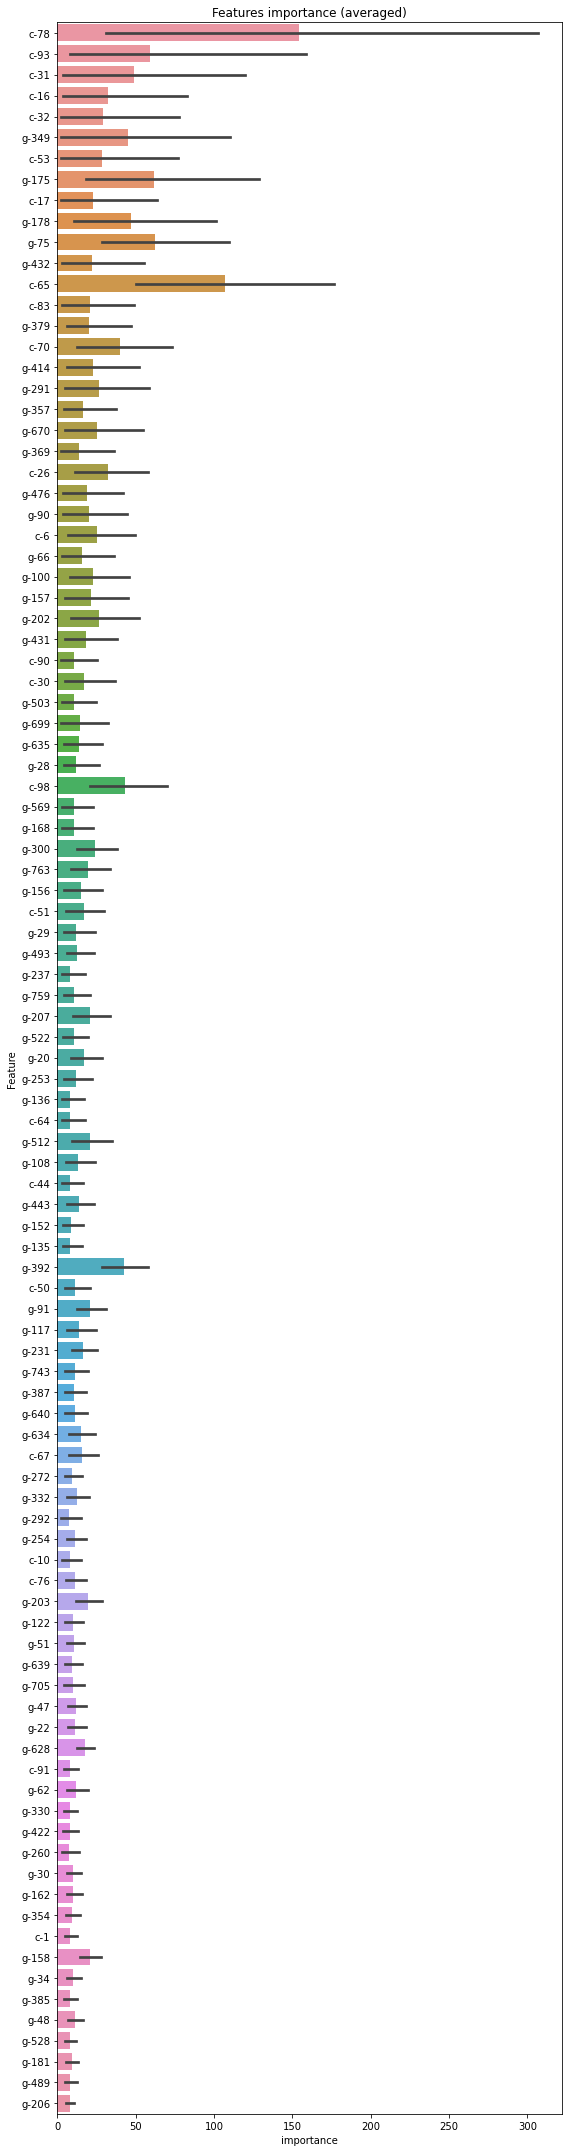

In [22]:
show_feature_importance(feature_importance_df)